In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [19]:

# Cargar el archivo df_train.parquet y df_test.parquet
train_dataset = pd.read_parquet('df_train.parquet')
test_dataset  = pd.read_parquet('df_test.parquet')

In [20]:
train_dataset.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [21]:
# Descripción de los tipos de datos del dataframe
print(train_dataset.dtypes)

MEDICAMENTOS                     float64
MEDICINA ESPECIALIZADA           float64
MEDICINA GENERAL                 float64
Cant_gr_flia                       int64
Cant_riesgos_flia_mean           float64
min_Tiempo_CP_Fliar              float64
Cant_Fliar_CP                    float64
psa_max_gr_flia                  float64
psa_min_gr_flia                  float64
Cant_Fliar_riesgos               float64
cantidad_serv_flia               float64
Pendiente_flia                   float64
Intercepto_flia                  float64
Promedio_costo_flia              float64
ESTADO_CIVI                       object
PROGRAMA                          object
estrato                           object
IMC                               object
AGRUPACION_SISTOLICA              object
AGRUPACION_DIASTOLICA             object
parentesco                        object
EDAD                             float64
RIESGOS                          float64
CANTIDAD_SERVICIOS               float64
PERDIDA_DE_PESO 

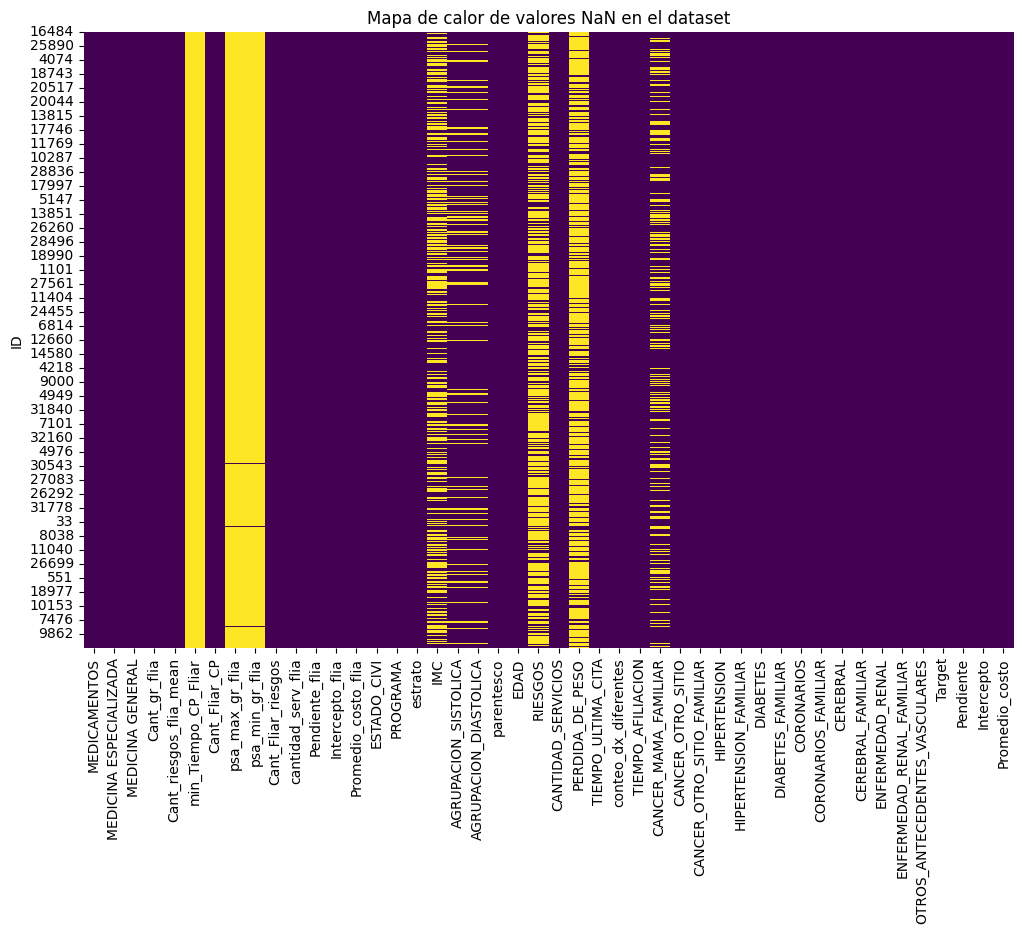

In [22]:
# Generar un mapa de calor de los valores NaN en el dataset
plt.figure(figsize=(12, 8))
sns.heatmap(train_dataset.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores NaN en el dataset')
plt.show()

In [23]:
# Calcular el porcentaje de valores NaN en cada columna
nan_percentage = (train_dataset.isnull().sum() / len(train_dataset)) * 100

# Calcular el porcentaje de valores NaN en cada columna, excluyendo las columnas que no tienen faltante
nan_percentage_filtered = nan_percentage[nan_percentage > 0].sort_values()
print(nan_percentage_filtered)

AGRUPACION_SISTOLICA     14.131268
AGRUPACION_DIASTOLICA    14.131268
CANCER_MAMA_FAMILIAR     28.952073
IMC                      44.113391
RIESGOS                  69.307057
PERDIDA_DE_PESO          75.436282
psa_max_gr_flia          99.301949
psa_min_gr_flia          99.301949
min_Tiempo_CP_Fliar      99.965949
dtype: float64


In [24]:
# BEGIN: Add columns with more than 75% missing values to columns_to_drop list
columns_to_drop = nan_percentage[nan_percentage > 75].index.tolist()
print(columns_to_drop)
# END: Add columns with more than 75% missing values to columns_to_drop list

['min_Tiempo_CP_Fliar', 'psa_max_gr_flia', 'psa_min_gr_flia', 'PERDIDA_DE_PESO']


In [25]:
train_dataset = train_dataset.drop(columns=columns_to_drop, axis=1)
test_dataset = test_dataset.drop(columns=columns_to_drop, axis=1)

# Mostrar las primeras filas del dataset limpio
train_dataset.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,Cant_Fliar_CP,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,0.0,0.0,34.0,15998.485714,-23363.200000,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,0.0,1.0,25.0,655.200000,-1019.200000,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,0.0,0.0,36.0,342236.971429,-521835.400000,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,0.0,0.0,24.0,-4468.285714,30687.333333,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,0.0,1.0,7.0,0.000000,0.000000,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


Separación de variables

In [6]:
numerical = train_dataset.select_dtypes(include=np.number).columns.tolist()
numerical.remove('Target')

nominal = train_dataset.select_dtypes(exclude=np.number).columns.tolist()
#nominal

ordinal = []


X = train_dataset[nominal + ordinal + numerical] 
y = train_dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_Kaggle_test = test_dataset[nominal + ordinal + numerical]

NameError: name 'train_dataset' is not defined

Pipelines auxiliares

Para separar mejor el procesamiento de nuestros datos, utilizamos tres pipelines auxiliares

In [27]:
# Pipeline datos ordinales
ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

# Pipeline datos nominales
nominal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=True, handle_unknown="ignore"))
])

# Pipeline datos numéricos
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Pegado de los tres pipelines
preprocessing_pipeline = ColumnTransformer([
    ("nominal_preprocessor", nominal_pipeline, nominal),
    ("ordinal_preprocessor", ordinal_pipeline, ordinal),
    ("numerical_preprocessor", numerical_pipeline, numerical)
])

In [47]:
ML_model = LinearRegression()
complete_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", ML_model)
])
print('LinearRegression', cross_val_score(complete_pipeline,X_train,y_train,cv=5).mean())

#complete_pipeline.fit(X_train, y_train)
#y_pred = complete_pipeline.predict(X_test)

#print('ERRORS OF PREDICTIONS')
#print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 
#print('MSE:', metrics.mean_squared_error(y_test, y_pred)) 
#print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
#print('r2_score:', r2_score(y_test, y_pred)) 


ML_model = Ridge(alpha=20)
complete_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", ML_model)
])
print('Ridge',cross_val_score(complete_pipeline,X_train,y_train,cv=5).mean())

ML_model = Lasso(alpha=190)
complete_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", ML_model)
])
print('Lasso',cross_val_score(complete_pipeline,X_train,y_train,cv=5).mean())


LinearRegression 0.030191913005388416
Ridge 0.03046367738302791
Lasso -0.0006037585855383388


In [38]:
complete_pipeline.fit(X_train, y_train)
y_pred = complete_pipeline.predict(X_test)

print('ERRORS OF PREDICTIONS')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 
print('MSE:', metrics.mean_squared_error(y_test, y_pred)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('r2_score:', r2_score(y_test, y_pred)) 
'''
true_value = y_test
predicted_value = y_pred

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()'''

ERRORS OF PREDICTIONS
MAE: 0.3939677626306794
MSE: 0.19737355101549972
RMSE: 0.4442674318645243
r2_score: 0.03733294016520061


"\ntrue_value = y_test\npredicted_value = y_pred\n\nplt.figure(figsize=(10,10))\nplt.scatter(true_value, predicted_value, c='crimson')\n# plt.yscale('log')\n# plt.xscale('log')\n\np1 = max(max(predicted_value), max(true_value))\np2 = min(min(predicted_value), min(true_value))\nplt.plot([p1, p2], [p1, p2], 'b-')\nplt.xlabel('True Values', fontsize=15)\nplt.ylabel('Predictions', fontsize=15)\nplt.axis('equal')\nplt.show()"

In [39]:
Pipeline

sklearn.pipeline.Pipeline

In [40]:
complete_pipeline 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ESTADO_CIVI', 'PROGRAMA',
                                                   'estrato', 'IMC',
                                                   'AGRUPACION_SISTOLICA',
                                                   'AGRUPACION_DIASTOLICA',
                                                   'parentesco',
                                                   'CANCER_MAMA_FAMILIAR',
                                                   'CANCER_OTRO_SIT...
                                                   'MEDICINA GENERAL',
                                                   'Cant_gr_flia',
                                                   'Cant_riesgos_flia_mean',
                                                   'Cant_Fliar_CP',
                                                   'Cant_Fliar_riesgos',
                                                   'cantidad_serv_flia',
                                                   'Pendiente_flia',
                                                   'Intercepto_flia',
                                                   'Promedio_costo_flia',
                                                   'EDAD', 'RIESGOS',
                                                   'CANTIDAD_SERVICIOS',
                                                   'TIEMPO_ULTIMA_CITA',
                                                   'conteo_dx_diferentes',
                                                   'TIEMPO_AFILIACION',
                                                   'Pendiente', 'Intercepto',
                                                   'Promedio_costo'])])),
                ('estimator', LinearRegression())])

In [41]:
cross_val_score

<function sklearn.model_selection._validation.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, params=None, pre_dispatch='2*n_jobs', error_score=nan)>

In [42]:
ordinal_pipeline 

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())])

In [44]:
nominal

['ESTADO_CIVI',
 'PROGRAMA',
 'estrato',
 'IMC',
 'AGRUPACION_SISTOLICA',
 'AGRUPACION_DIASTOLICA',
 'parentesco',
 'CANCER_MAMA_FAMILIAR',
 'CANCER_OTRO_SITIO',
 'CANCER_OTRO_SITIO_FAMILIAR',
 'HIPERTENSION',
 'HIPERTENSION_FAMILIAR',
 'DIABETES',
 'DIABETES_FAMILIAR',
 'CORONARIOS',
 'CORONARIOS_FAMILIAR',
 'CEREBRAL',
 'CEREBRAL_FAMILIAR',
 'ENFERMEDAD_RENAL',
 'ENFERMEDAD_RENAL_FAMILIAR',
 'OTROS_ANTECEDENTES_VASCULARES']

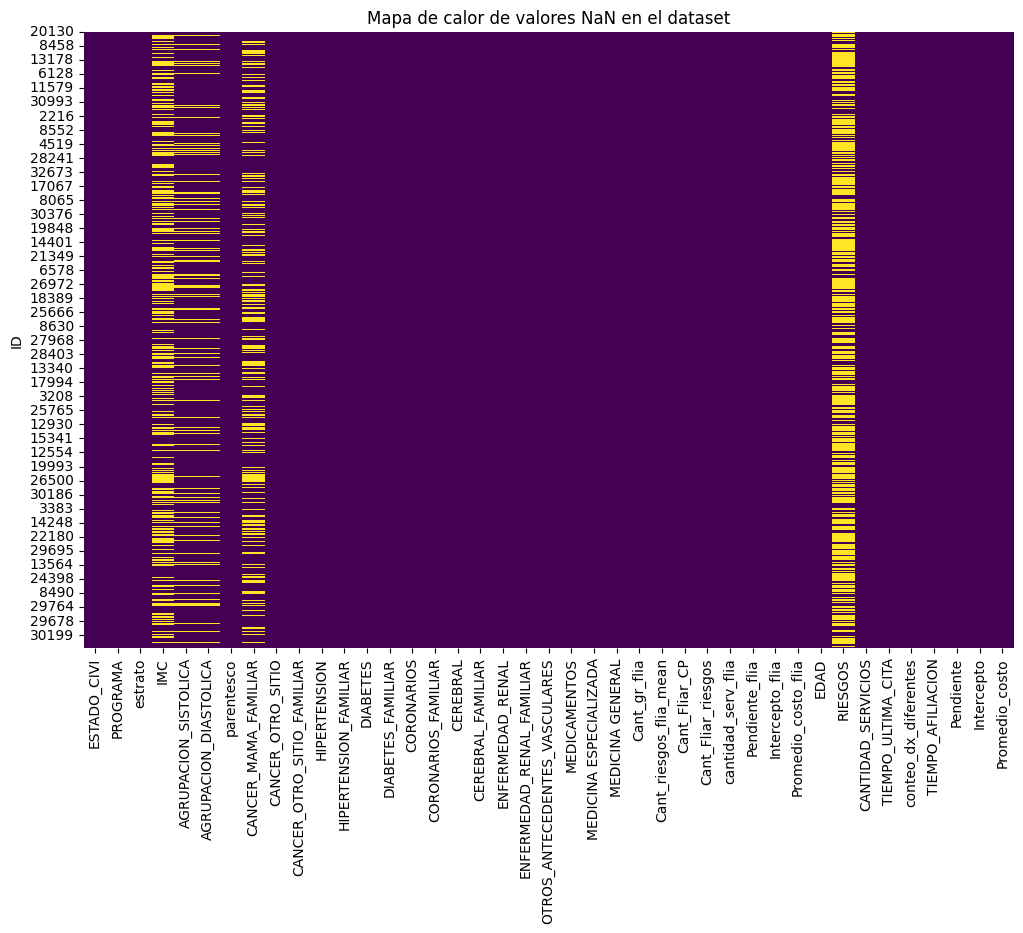

In [43]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores NaN en el dataset')
plt.show()

## 1: Comprensión y Preparación de los Datos

### 1.1: Análisis Exploratorio de Datos (EDA)

#### 1.1.1: Revisión del Conjunto de Datos

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

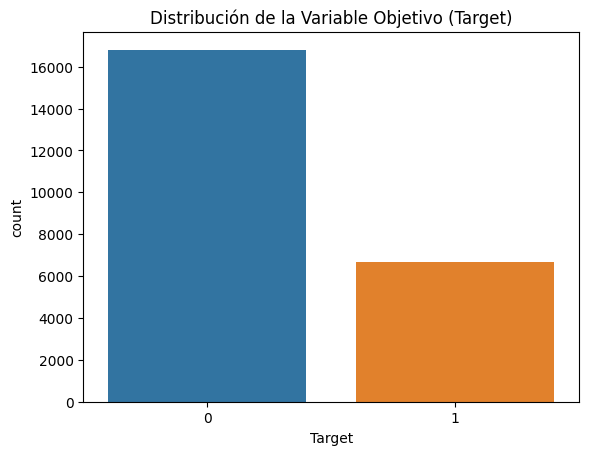

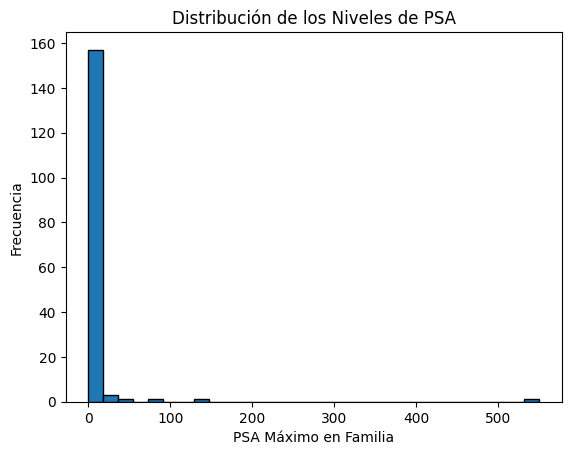

In [3]:
data_df = pd.read_parquet('df_train.parquet')

# Obtener información básica del dataset
print(data_df.info())  # Ver los tipos de datos y si hay valores nulos
print(data_df.describe())  # Estadísticas descriptivas de las variables numéricas
print(data_df.head())  # Primeras filas del dataset para familiarizarse con las columnas

# Visualizar la distribución de la variable objetivo "Target"
sns.countplot(x='Target', data=data_df)
plt.title('Distribución de la Variable Objetivo (Target)')
plt.show()

# Histograma de una variable importante como el PSA
plt.hist(data_df['psa_max_gr_flia'].dropna(), bins=30, edgecolor='black')
plt.title('Distribución de los Niveles de PSA')
plt.xlabel('PSA Máximo en Familia')
plt.ylabel('Frecuencia')
plt.show()

#### 1.1.2: Análisis del Baseline

Baseline ROC_AUC: 0.7819378741690961


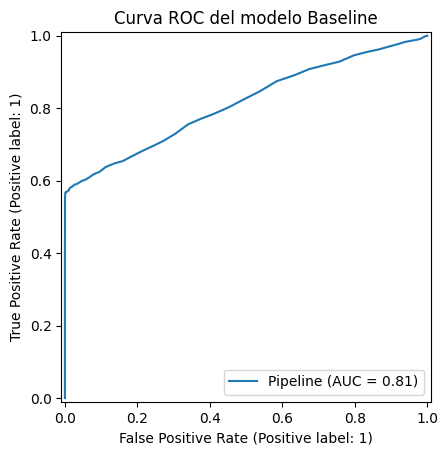

In [13]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Separar las variables predictoras y la variable objetivo
X = data_df.drop('Target', axis=1)  # Elimina la columna objetivo 'Target'
y = data_df['Target']  # Columna objetivo

# Identificar variables categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
num_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear un transformador para las variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),  # Imputación en numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHotEncoding en categóricas
    ])

# Crear un pipeline con el preprocesador y un modelo de Random Forest
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformaciones en los datos
    ('model', RandomForestClassifier(random_state=42))  # Modelo Random Forest
])

# Entrenar el modelo con el pipeline
baseline_pipeline.fit(X_train, y_train)

# Predecir los resultados en el conjunto de prueba
y_pred = baseline_pipeline.predict(X_test)

# Evaluar el modelo con la métrica de ROC AUC
auc = roc_auc_score(y_test, y_pred)
print(f"Baseline ROC_AUC: {auc}")
# Graficar la curva ROC
RocCurveDisplay.from_estimator(baseline_pipeline, X_test, y_test)
plt.title('Curva ROC del modelo Baseline')
plt.show()

El modelo inicial que construimos tiene una capacidad del 78.19% para distinguir entre pacientes con niveles de PSA anormales y normales. Este es un buen punto de partida para nuestro análisis, ya que nos da una base sólida sobre la cual podemos trabajar. Aún así, sabemos que en el ámbito médico, donde la detección temprana es crítica, queremos reducir al mínimo el margen de error. Por eso, continuaremos optimizando el modelo para mejorar su precisión

### 1.2: Identificación de Problemas en los Datos

#### 1.2.1: Análisis de Valores Faltantes

#### 1.2.2: Análisis de Outliers

### 1.3: Imputación de Valores Faltantes y Transformaciones

#### 1.3.1: Imputación de Valores Faltantes

### 1.4: Transformaciones Adicionales con Pipelines

#### 1.4.1: Normalización y Escalado

#### 1.4.2: Dummificación de Variables Categóricas

## 2: Feature Engineering y Optimización del Flujo de Trabajo

### 2.1: Transformaciones de Datos en el Pipeline

#### 2.2.1: Tratamiento de Variables Categóricas

#### 2.2.2: Uso de PCA para Reducción de Dimensionalidad

#### 2.2.3: Selección de Variables Relevantes

### 2.2: Construcción de Pipelines Complejos para el Modelado

#### 2.2.1: Construcción de un Pipeline Completo